## Random Forest Analysis

In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv("./weatherAUS_cleaned.csv", index_col="Date")
df_melb = df[df.Location == "Melbourne"].copy().drop(columns=["Location"])
df_melb.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Temp,RainToday,RISK_MM,RainTomorrow,is9AM,Latitude,Longitude
Date,,,,,,,,,,,,,,,,
2008-07-01,9.5,15.4,2.0,12.0,63.0,12.0,37.0,60.0,1006.8,11.0,1,0.6,0,1,-37.814218,144.963161
2008-07-02,11.0,14.5,0.6,12.0,63.0,12.0,30.0,66.0,1013.4,11.8,0,1.4,1,1,-37.814218,144.963161
2008-07-03,8.4,14.1,1.4,12.0,39.0,12.0,17.0,72.0,1024.8,10.6,1,0.6,0,1,-37.814218,144.963161
2008-07-04,9.1,14.5,0.6,4.0,19.0,15.0,9.0,87.0,1030.2,10.2,0,0.0,0,1,-37.814218,144.963161
2008-07-05,4.3,15.5,0.0,0.0,52.0,0.0,24.0,81.0,1028.9,5.5,0,0.0,0,1,-37.814218,144.963161


In [50]:
# shift dataframes to make supervisable
# n_train_days: number of days in the past to observe
# n_pred_days: number of days into the future to predict
def shift_ts_data(df, n_train_days=1, n_pred_days=0, pred_col="RainToday"):
    df_temp = df.copy()
    cols = list()
    for i in range(n_train_days, 0, -1):
        cols.append(df_temp.shift(i))

    cols.append(df_temp.shift(-n_pred_days)[pred_col])

    agg = pd.concat(cols, axis=1)
    return agg.values, agg

In [62]:
# Make prediction for single value
def train_rf(train, pred_idx, clf=False):
    train = np.asarray(train)
    X, y = np.delete(train, pred_idx, 1), train[:, pred_idx]
    if clf:
        print("Using RFC")
        model = RandomForestClassifier(criterion='gini', n_estimators=50, random_state=402)
    else:
        print("Using RFR")
        model = RandomForestRegressor(criterion='friedman_mse', n_estimators=400, random_state=402)
    model.fit(X, y)
    return model

# Run model on dataset
def validate_rf(data, test_size=None):
    pred_idx = -1
    if test_size is None:
        test_size = 0
    if type(test_size) is float:
        test_size = min(int(len(data) * test_size), len(data))

    train, test = data[:-test_size, :], data[-test_size:, :]
    testX, testY = np.delete(test, pred_idx, 1), test[:, pred_idx]

    prev_samples = train.tolist()
    predictions = list()
    
    clf = len(np.unique(testY)) < 4

    model = train_rf(train, pred_idx, clf)
    for i in range(test_size):
        X, y = testX[i], testY[i]
        y_hat = model.predict([X])[0]

        predictions.append(y_hat)
        prev_samples.append(test[i])
        if i % 50 == 0:
            print("===={}% done====".format(i * 100 / test_size))

    if clf:
        metric = accuracy_score(test[:, pred_idx], predictions)
    else: 
        metric = mean_squared_error(test[:, pred_idx], predictions)

    return metric, test[:, pred_idx], predictions

In [74]:
df_melb_cln = df_melb.drop(columns=["RainTomorrow", "RISK_MM"])
shift_melb, shift_df = shift_ts_data(df_melb_cln, n_train_days=3, n_pred_days=1, pred_col="MaxTemp")
shift_melb = shift_melb[~np.isnan(shift_melb).any(axis=1)]

MSE, y, y_hat = validate_rf(shift_melb, 365)

Using RFR
====0.0% done====
====13.698630136986301% done====
====27.397260273972602% done====
====41.0958904109589% done====
====54.794520547945204% done====
====68.4931506849315% done====
====82.1917808219178% done====
====95.89041095890411% done====


Metric: 10.388


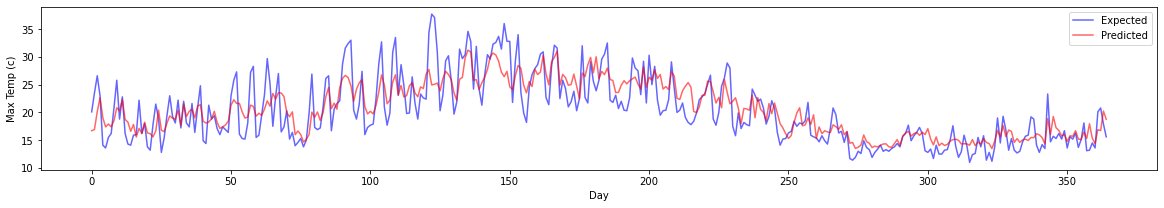

In [77]:
print('Metric: %.3f' % MSE)
plt.rcParams["figure.figsize"] = (20,3)
# plot expected vs predicted
plt.plot(y, label='Expected', marker="", color='b', alpha=.6)
plt.plot(y_hat, label='Predicted', marker="", color='r', alpha=.6)
plt.legend()
plt.xlabel("Day")
plt.ylabel("Max Temp (c)")
# plt.title("Weather prediction in Melbourne, AU")
plt.show()

In [76]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


show_plot(
    [shift_melb[0][:, 1].numpy(), y[0].numpy(), y_hat[0]],
    12,
    "Single Step Prediction",
)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed